# Training an MLP using all of the data provided

The goal is to explore the classification of proteins into Carbohydrate Active enzymes (CAZymes) and non-CAZymes. A simple MLP is trained on a dataset of classified non-PULs (Polysaccharide Utilisation Loci) using sklearn, then applied to the dataset of PULs. The methods and results are presented below, analysing the model's ability to accurately classify proteins.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re
import math

import h5py
import json

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score


## 1. Load all files & put into dataframes

Negative training data:
- `pfam_training_data_augment.h5`
- `non_cazy_kegg.h5`

Positive training data:
- `vicreg_train_val_embeddings_noCAZOME_noLargeSeqs_combined.h5` (+ use `cazy_family_by_taxa_60.json` to pick a representative sample across all enzyme classes)


In [4]:
PUL_embeddings = []
PUL_keys = []
with h5py.File('C:\\Users\\alpha\Documents\\jennifer\\maths\\SRIM\\code\\PUL.h5', 'r') as f:
    for key in f.keys():
        PUL_embeddings.append(np.array(f[key][()]))
        PUL_keys.append(key)
        


In [5]:
PFAM_embeddings = []
PFAM_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\pfam_training_data_augment.h5', 'r') as f:
    for key in f.keys():
        PFAM_embeddings.append(f[key][()])
        PFAM_keys.append(key)

In [6]:
kegg_embeddings = []
kegg_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\non_cazy_kegg.h5', 'r') as f:
    for key in f.keys():
        kegg_embeddings.append(f[key][()])
        kegg_keys.append(key)

All of the PULs are stored in `PUL_df`, where the last column indicates if each protein is a CAZyme (1) or not (0):

In [7]:
#PUL file:
from Bio import SeqIO
import seaborn as sns
f_path = 'C:\\Users\\alpha\\OneDrive - University of Cambridge\\BACKUP 14-04-22\\docs\\Maths\\SRIM\\code\\PUL.faa'
PUL_array, PUL_keys2 = [], []

with open(f_path, mode='r') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        identifier, description = record.id, record.description
        PUL_keys2.append(identifier)
        if 'CAZyme' in description:
            PUL_array.append(1)
        else:
            PUL_array.append(0)

PUL_array = np.array(PUL_array)
PUL_array = PUL_array.reshape(np.shape(PUL_array)[0],-1)
PUL_array_df = pd.DataFrame(PUL_array, index=PUL_keys2,columns=['cazy'])

col_label=['emb'+str(i) for i in range(len(list(PUL_embeddings)[0]))]
# col_label.append('cazy')

PUL_embeddings_list=list(PUL_embeddings)
temp_df = pd.DataFrame(PUL_embeddings_list, index=PUL_keys, columns=['emb'+str(i) for i in range(len(list(PUL_embeddings)[0]))])

# PUL_df = pd.DataFrame(data=np.concatenate([PUL_embeddings,PUL_array], axis=1), index=PUL_keys2, columns=col_label)
PUL_df = temp_df.join(PUL_array_df)

#indexing issue fixed

In [8]:
PUL_df

,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,...,emb1015,emb1016,emb1017,emb1018,emb1019,emb1020,emb1021,emb1022,emb1023,cazy
PUL0001_1,0.017563,0.059692,0.030075,0.007584,-0.032013,0.063904,-0.044128,-0.086609,0.033752,-0.031281,...,-0.049255,-0.006824,-0.111633,0.083191,0.030334,-0.028244,-0.008194,0.031616,0.025970,1
PUL0001_10,-0.014236,0.032715,0.034546,-0.026245,0.007820,-0.001535,-0.026840,-0.044830,-0.022736,0.003244,...,-0.020203,0.010963,-0.120483,0.041931,0.013710,0.003368,-0.005569,0.021667,-0.024216,0
PUL0001_11,-0.019104,0.034027,0.051361,0.030670,-0.013756,0.012695,-0.019608,-0.076233,0.047943,0.000046,...,-0.042297,-0.000536,-0.089661,0.064331,-0.042755,-0.018158,-0.025391,0.001602,0.011215,0
PUL0001_12,0.047211,0.002373,0.000755,0.020142,-0.008369,0.028976,-0.000050,-0.083252,0.017487,-0.002466,...,-0.031281,-0.036804,-0.075195,0.022964,0.014938,-0.035187,-0.028992,0.069641,-0.001657,0
PUL0001_13,0.024719,0.031494,0.027359,0.021515,-0.007629,0.024506,-0.014908,-0.058167,-0.014183,-0.020538,...,0.004028,0.015884,-0.064758,0.049774,-0.009315,0.007256,0.006168,0.060211,0.017761,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PUL0602_5,0.017685,0.051422,0.006428,-0.001532,0.006233,0.035370,-0.035553,-0.049744,0.028076,0.002031,...,-0.006264,-0.016479,-0.024261,0.067261,0.056061,-0.026321,0.032532,-0.009926,0.066528,1
PUL0602_6,0.009483,0.044464,0.050842,-0.036957,0.004826,-0.014664,-0.014572,-0.093689,-0.026871,0.017822,...,-0.001588,0.013908,-0.104553,0.027496,0.050049,-0.053558,0.024475,0.020248,0.038025,0
PUL0602_7,0.051819,0.009346,0.015388,-0.028381,0.013084,0.042877,-0.026932,-0.030212,0.031433,0.006268,...,-0.001817,0.013542,-0.069275,0.019424,-0.009377,-0.048309,0.009567,0.007690,-0.010933,0
PUL0602_8,0.032349,0.047760,0.041046,-0.033142,0.004124,0.082153,-0.036713,-0.099487,-0.023865,0.007652,...,-0.015564,0.004181,-0.069214,0.032410,0.000823,0.000344,-0.011467,0.043060,0.034729,0


Non-PUL negative (non-CAZyme) data is stored in `non_cazy_df`:

In [9]:
#non-cazymes:
non_cazy_embeddings = np.concatenate([PFAM_embeddings,kegg_embeddings], axis=0)
non_cazy_keys = np.concatenate([PFAM_keys, kegg_keys], axis=0)
non_cazy_df = pd.DataFrame(data=non_cazy_embeddings, index=non_cazy_keys, columns=['emb'+str(i) for i in range(len(list(non_cazy_embeddings)[0]))])
non_cazy_df = non_cazy_df.join(pd.DataFrame(data=np.zeros(np.array(non_cazy_keys).shape[0]), index=non_cazy_keys, columns=['cazy']), how='inner')


In [10]:
cazy_embeddings = []
cazy_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\vicreg_train_val_embeddings_noCAZOME_noLargeSeqs_combined.h5', 'r') as f:
    for key in f.keys():
        cazy_embeddings.append(f[key][()])
        cazy_keys.append(key)

In [11]:
# print(np.shape(PUL_embeddings))
# print(np.shape(non_cazy_embeddings))
# print(np.shape(cazy_embeddings))

## 2. Create lookup using .json file

To obtain a representative sample of CAZymes to use as positive training data, we create a lookup for each class using `cazy_family_by_taxa_60.json`:

In [12]:
family_ids = []
family_keys = []
file = open('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\cazy_family_by_taxa_60.json')

In [13]:
cazy_ids = []
cazy_families = []
file = open('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\cazy_family_by_taxa_60.json')
data = json.loads(file.read())

for key in data.keys(): #keys are IDs, values are classes
        cazy_ids.append(key)
        cazy_families.append(data.get(key))


In [14]:
# cazy_df = pd.DataFrame(data=concat , columns=['id','class'])
cazy_df_2 = pd.DataFrame(data=cazy_families, index=cazy_ids , columns=['class'])

Create dataframe of cazymes with extra columnns containing embeddings, then inner join with cazy_df_2 (intersect dataframes at indices)

In [15]:
cazy_df_1 = pd.DataFrame(data=cazy_embeddings, index=cazy_keys, columns=['emb'+str(i) for i in range(len(list(cazy_embeddings)[0]))])

# long (~17 min)

In [16]:
cazy_df = cazy_df_2.join(cazy_df_1, how='inner')
print(cazy_df)

             class      emb0      emb1      emb2      emb3      emb4  \
AZS17016.1  GH13_2  0.049500  0.037415 -0.038025  0.031235  0.017197   
AVO05213.1    GH32 -0.014870  0.036865  0.009872 -0.011703  0.015808   
QPG94344.1    GT61  0.016739 -0.028412  0.026016  0.017227  0.013565   
APD47233.1     GT4  0.015976 -0.009315 -0.032532  0.033173  0.011223   
ANU32067.1     GT4  0.010872 -0.021881 -0.008972 -0.013237  0.000924   
...            ...       ...       ...       ...       ...       ...   
QMI07227.1    GT83 -0.008034 -0.009453  0.029785  0.033478  0.024063   
UMA63307.1     GT2  0.019272 -0.044830  0.024490  0.026031  0.026672   
UPW01296.1     GT4  0.055878 -0.059723 -0.039551 -0.001044  0.057983   
ULL17023.1    GH43  0.013275  0.033997  0.013687  0.021133  0.018799   
USF23742.1     GT9  0.022705 -0.043182 -0.023972  0.007046 -0.025818   

                emb5      emb6      emb7      emb8  ...   emb1014   emb1015  \
AZS17016.1  0.031616 -0.019043 -0.046234  0.007179  ... 

In [17]:
cazy_GH_df = cazy_df[cazy_df['class'].str.contains('GH')]
cazy_GT_df = cazy_df[cazy_df['class'].str.contains('GT')]
cazy_PL_df = cazy_df[cazy_df['class'].str.contains('PL')]
cazy_CE_df = cazy_df[cazy_df['class'].str.contains('CE')]

allclasses=['GH', 'GT', 'PL', 'CE']
cazy_other_df = cazy_df[cazy_df['class'].str.contains('|'.join(allclasses))]

#then use pd.DataFrame.sample to take random sample of items across axis 0


[size of first four dataframes add up to 232736 so in fact no other classes to account for]

Sample proportionally to size of each class:

In [18]:
x=5000/232736
new_cazy_GH_df = cazy_GH_df.sample(frac=x, axis=0)
new_cazy_GT_df = cazy_GT_df.sample(frac=x, axis=0)
new_cazy_PL_df = cazy_PL_df.sample(frac=x, axis=0)
new_cazy_CE_df = cazy_CE_df.sample(frac=x, axis=0)

Concatenate into one DataFrame:

Positive training data is stored in `cazy_train_df` (5001 embeddings):

In [19]:
cazy_train_df = pd.concat([new_cazy_GH_df, new_cazy_GT_df, new_cazy_PL_df, new_cazy_CE_df], axis=0)
cazy_train_df = cazy_train_df.join(pd.DataFrame(data=np.ones(np.array(cazy_ids).shape[0]), index=cazy_ids, columns=['cazy']), how='inner')

In [20]:
cazy_train_df

,class,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,...,emb1015,emb1016,emb1017,emb1018,emb1019,emb1020,emb1021,emb1022,emb1023,cazy
QCK14469.1,GH3,0.044281,0.047058,0.003883,0.009415,-0.018250,0.031616,-0.059906,-0.085632,-0.023880,...,-0.032166,-0.013802,-0.031769,0.044586,0.005478,0.010086,0.008987,0.055054,0.028763,1.0
QVM84581.1,GH16_7,0.007217,-0.007271,-0.012390,-0.009834,-0.017166,0.027451,-0.013519,-0.061340,0.007294,...,-0.017899,-0.003252,-0.067139,0.002676,0.069153,0.054871,0.024704,0.046356,0.001888,1.0
BDI31625.1,GH2,-0.007317,0.025101,0.046173,0.007732,0.029190,0.011421,-0.029831,-0.113831,-0.038330,...,-0.021759,0.010727,-0.059845,0.017166,-0.005936,-0.012108,0.007092,0.063782,0.025909,1.0
QKY15164.1,GH13,0.023697,-0.017242,-0.023682,-0.001486,-0.009109,0.054291,-0.082458,-0.000108,0.012192,...,-0.021545,0.013039,-0.109497,0.013252,0.048737,-0.008850,-0.016464,0.070496,0.026978,1.0
BAE68792.1,GH144,0.025192,0.064514,0.049377,0.016327,0.016876,0.014908,-0.045471,-0.049164,0.035339,...,-0.008202,-0.014206,-0.031281,0.042633,0.039307,-0.010406,0.017380,0.035675,0.061523,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BCJ64381.1,CE14,-0.000723,-0.008530,0.033112,0.034088,0.029251,0.024460,-0.013931,-0.094604,0.059265,...,-0.019257,-0.005161,-0.040436,-0.019806,-0.011398,-0.021683,0.023117,0.004906,0.015717,1.0
QUT38028.1,CE2,0.039001,0.047852,-0.006821,0.025452,-0.011909,0.051880,-0.022949,-0.098938,-0.016785,...,-0.041626,-0.005524,-0.056030,0.048828,0.025192,-0.028839,-0.038239,0.053375,-0.005638,1.0
QIK52227.1,CE20,-0.025238,0.022675,-0.000809,-0.028503,0.004105,0.030396,-0.061279,-0.092773,0.001772,...,-0.022430,0.008362,-0.083252,0.035797,0.033478,0.003216,0.031204,0.040558,0.012703,1.0
QFZ18918.1,CE3,0.049927,0.009659,0.020523,-0.012611,0.026337,-0.011818,-0.024612,-0.080872,-0.023300,...,-0.022720,-0.024231,-0.031586,0.030228,0.000024,-0.043335,0.031860,-0.040497,-0.012436,1.0


## 3. Create training dataframe + train a simple MLP


Negative training data is stored in `non_cazy_df`: (10,000 samples)

In [21]:
non_cazy_train_df = non_cazy_df.sample(n=10000, axis=0)

### (a) Using PUL file entirely for inference; `train_df` for training:


Concatenate non-cazy and cazy training dataframes into `train_df` (size = 10000 + 5001):

In [22]:
train_df = pd.concat([cazy_train_df, non_cazy_train_df], axis=0).iloc[:,1:] #removes 'class' column

In [23]:
X_train, y_train = np.array(train_df.iloc[:,:-1]), np.array(train_df.iloc[:,-1:])
X_test, y_test = np.array(PUL_df.iloc[:,:-1]), np.array(PUL_df.iloc[:,-1:])

In [24]:
vec = np.ones(20,)*100
vec = [int(x) for x in vec]

In [25]:
mlp = MLPClassifier(hidden_layer_sizes=vec,
                     activation = 'relu',
                     solver = 'adam',
                     verbose = True).fit(X_train,y_train)

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.36333846
Iteration 2, loss = 0.04861485
Iteration 3, loss = 0.03088845
Iteration 4, loss = 0.02902018
Iteration 5, loss = 0.01638579
Iteration 6, loss = 0.01388985
Iteration 7, loss = 0.01027485
Iteration 8, loss = 0.00939138
Iteration 9, loss = 0.01420277
Iteration 10, loss = 0.01052225
Iteration 11, loss = 0.00558290
Iteration 12, loss = 0.00507670
Iteration 13, loss = 0.00997447
Iteration 14, loss = 0.00262680


c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
y_pred = mlp.predict(X_test)

In [ ]:
print(accuracy_score(y_test,y_pred))
#confusion matrix
mat = confusion_matrix(y_test, y_pred)
cfmat_df = pd.DataFrame(np.array(mat))
index_, columns_ = ['Not_cazyme','Cazyme'], ['Pred_not_cazyme', 'Pred_cazyme']
cfmat_df.index, cfmat_df.columns = index_, columns_

print(cfmat_df)

print('negative accuracy= ', cfmat_df.iloc[0,0]/sum(cfmat_df.iloc[0,:]))
print('positive accuracy= ', cfmat_df.iloc[1,1]/sum(cfmat_df.iloc[1,:]))

0.8141317054162879
            Pred_not_cazyme  Pred_cazyme
Not_cazyme             4635         1399
Cazyme                   32         1633
negative accuracy=  0.768147166058999
positive accuracy=  0.9807807807807808



- Using PUL file entirely for inference produces poor results, worse than trivial classifier (78.4%) (!)
- positive prediction is much better (~99%) than negative (~64%) (why?)
- Increasing number of layers generally gives worse accuracy; at a large (>50) number of layers, the whole test set is classfied as non-cazyme ie a trivial classifier

<!-- **2 layers:** (relu)
- 76.2% (10,10); 74.7% (100,100)

**3 layers:**
- 70.3% (10,10,10); 69.2% (100,100,100)

**4 layers:**
 - 72.6% (10,10,10,10) -->

The accuracy and AUC scores are displayed below, for MLPs of varying depth and fixed layer sizes (10 at each layer).

- As number of layers increases past 3, the accuracy and AUC score decreases. AUC score is calculated below

    (more neurons neeeded at each layer?)


| no. layers | accuracy | AUC   |
|------------|----------|-------|
| 2          | 0.803    | 0.934 |
| 3          | 0.807    | 0.924 |
| 4          | 0.800    | 0.940 |
| 5          | 0.801    | 0.929 |
| 10         | 0.775    | 0.933 |
| 20         | 0.766    | 0.859 |
| 100        | 0.784    | 0.500 |

When size of each layer is increased to 100, the increase in accuracy and AUC score is greater for models with greater depth (as expected):

| no. layers | accuracy | AUC   |
|------------|----------|-------|
| 2          | 0.792    | 0.935 |
| 3          | 0.817    | 0.939 |
| 4          | 0.805    | 0.936 |
| 5          | 0.831    | 0.937 |
| 10         | 0.831    | 0.938 |
| 20         | 0.814    | 0.939 |

### Using RandomizedSearchCV for hyperparameter tuning of a 3 layer MLP:


In [ ]:
templist = []
for i in range(2,10):
    for j in range(2,10):
        for k in range(2,10):
            templist.append((i,j,k))

distributions = {'hidden_layer_sizes':templist,
              'activation':('logistic','relu')
              }

#layer norm
# regularise weights


clf = RandomizedSearchCV(estimator=mlp, param_distributions=distributions, cv=5, verbose=1) #, refit=True)

<!-- Best parameters: 'hidden_layer_sizes': (7, 2, 4), (3, 8, 7), 'activation': 'logistic' -->

[Q: Large variance in best parameters (x,y,z) after running the whole notebook several times - but the randomness in selecting training data should not affect this?]

No large increase in accuracy (~0.1%); still quite poor.

Fitting this "optimal" 3-layer MLP:

In [ ]:
clf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.02179484
Iteration 2, loss = 0.89383048
Iteration 3, loss = 0.78807026
Iteration 4, loss = 0.71436478
Iteration 5, loss = 0.66082358
Iteration 6, loss = 0.62852736
Iteration 7, loss = 0.60196286
Iteration 8, loss = 0.57762651
Iteration 9, loss = 0.55485516
Iteration 10, loss = 0.53315048
Iteration 11, loss = 0.51265888
Iteration 12, loss = 0.49314245
Iteration 13, loss = 0.47443681
Iteration 14, loss = 0.45646560
Iteration 15, loss = 0.43941713
Iteration 16, loss = 0.42290946
Iteration 17, loss = 0.40719877
Iteration 18, loss = 0.39213501
Iteration 19, loss = 0.37759052
Iteration 20, loss = 0.36387261
Iteration 21, loss = 0.35081424
Iteration 22, loss = 0.33786861
Iteration 23, loss = 0.32602138
Iteration 24, loss = 0.31424889
Iteration 25, loss = 0.30302390
Iteration 26, loss = 0.29245290
Iteration 27, loss = 0.28211310
Iteration 28, loss = 0.27233989
Iteration 29, loss = 0.26301739
Iteration 30, loss = 0.25407921
Iteration 31, loss = 0.24523764
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.71434244
Iteration 2, loss = 0.38703201
Iteration 3, loss = 0.14851434
Iteration 4, loss = 0.09362885
Iteration 5, loss = 0.07114289
Iteration 6, loss = 0.05876805
Iteration 7, loss = 0.05118705
Iteration 8, loss = 0.04579027
Iteration 9, loss = 0.04195397
Iteration 10, loss = 0.03866569
Iteration 11, loss = 0.03632632
Iteration 12, loss = 0.03398956
Iteration 13, loss = 0.03196898
Iteration 14, loss = 0.03032810
Iteration 15, loss = 0.02851133
Iteration 16, loss = 0.02694771
Iteration 17, loss = 0.03186748
Iteration 18, loss = 0.02627731
Iteration 19, loss = 0.02506518
Iteration 20, loss = 0.02555956
Iteration 21, loss = 0.02367689
Iteration 22, loss = 0.02279113
Iteration 23, loss = 0.02201356
Iteration 24, loss = 0.02125659
Iteration 25, loss = 0.02073130
Iteration 26, loss = 0.02005747
Iteration 27, loss = 0.01927687
Iteration 28, loss = 0.01871769
Iteration 29, loss = 0.01816328
Iteration 30, loss = 0.02445155
Iteration 31, loss = 0.01846954
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.61230969
Iteration 2, loss = 0.51795896
Iteration 3, loss = 0.38987906
Iteration 4, loss = 0.26426119
Iteration 5, loss = 0.15042051
Iteration 6, loss = 0.08559968
Iteration 7, loss = 0.06121402
Iteration 8, loss = 0.05096206
Iteration 9, loss = 0.04549556
Iteration 10, loss = 0.04164085
Iteration 11, loss = 0.03893521
Iteration 12, loss = 0.03696168
Iteration 13, loss = 0.03489585
Iteration 14, loss = 0.03312158
Iteration 15, loss = 0.03161205
Iteration 16, loss = 0.03001615
Iteration 17, loss = 0.02873825
Iteration 18, loss = 0.02711485
Iteration 19, loss = 0.02550387
Iteration 20, loss = 0.02410807
Iteration 21, loss = 0.02328955
Iteration 22, loss = 0.02229295
Iteration 23, loss = 0.02169789
Iteration 24, loss = 0.02045203
Iteration 25, loss = 0.02046342
Iteration 26, loss = 0.01942049
Iteration 27, loss = 0.01877503
Iteration 28, loss = 0.01807651
Iteration 29, loss = 0.01722760
Iteration 30, loss = 0.01687207
Iteration 31, loss = 0.01629147
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.07471275
Iteration 2, loss = 0.98097114
Iteration 3, loss = 0.88583436
Iteration 4, loss = 0.80936568
Iteration 5, loss = 0.75395548
Iteration 6, loss = 0.71903415
Iteration 7, loss = 0.68863257
Iteration 8, loss = 0.66020553
Iteration 9, loss = 0.63356692
Iteration 10, loss = 0.60853656
Iteration 11, loss = 0.58478023
Iteration 12, loss = 0.56207064
Iteration 13, loss = 0.54054549
Iteration 14, loss = 0.52007329
Iteration 15, loss = 0.50019668
Iteration 16, loss = 0.48098019
Iteration 17, loss = 0.46281625
Iteration 18, loss = 0.44524048
Iteration 19, loss = 0.42865512
Iteration 20, loss = 0.41266152
Iteration 21, loss = 0.39736933
Iteration 22, loss = 0.38295993
Iteration 23, loss = 0.36920732
Iteration 24, loss = 0.35555681
Iteration 25, loss = 0.34295783
Iteration 26, loss = 0.33076793
Iteration 27, loss = 0.31887883
Iteration 28, loss = 0.30771371
Iteration 29, loss = 0.29654851
Iteration 30, loss = 0.28608365
Iteration 31, loss = 0.27656159
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.48439781
Iteration 2, loss = 0.30649481
Iteration 3, loss = 0.23805189
Iteration 4, loss = 0.19647455
Iteration 5, loss = 0.16728129
Iteration 6, loss = 0.14449204
Iteration 7, loss = 0.12570064
Iteration 8, loss = 0.11158040
Iteration 9, loss = 0.09601940
Iteration 10, loss = 0.08278025
Iteration 11, loss = 0.07041324
Iteration 12, loss = 0.05851227
Iteration 13, loss = 0.04681001
Iteration 14, loss = 0.03737118
Iteration 15, loss = 0.03047386
Iteration 16, loss = 0.02638223
Iteration 17, loss = 0.02344722
Iteration 18, loss = 0.02154857
Iteration 19, loss = 0.01975648
Iteration 20, loss = 0.01840426
Iteration 21, loss = 0.01708207
Iteration 22, loss = 0.01588794
Iteration 23, loss = 0.01490489
Iteration 24, loss = 0.01391833
Iteration 25, loss = 0.01310812
Iteration 26, loss = 0.01201162
Iteration 27, loss = 0.01117470
Iteration 28, loss = 0.01039509
Iteration 29, loss = 0.00979446
Iteration 30, loss = 0.00900707
Iteration 31, loss = 0.00811756
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.88729822
Iteration 2, loss = 0.71779314
Iteration 3, loss = 0.57669266
Iteration 4, loss = 0.46595950
Iteration 5, loss = 0.41167626
Iteration 6, loss = 0.37260621
Iteration 7, loss = 0.33951397
Iteration 8, loss = 0.31090604
Iteration 9, loss = 0.28613672
Iteration 10, loss = 0.26403163
Iteration 11, loss = 0.24445357
Iteration 12, loss = 0.22672762
Iteration 13, loss = 0.21126193
Iteration 14, loss = 0.19926274
Iteration 15, loss = 0.18790607
Iteration 16, loss = 0.17808382
Iteration 17, loss = 0.17180589
Iteration 18, loss = 0.16606117
Iteration 19, loss = 0.16044555
Iteration 20, loss = 0.15512242
Iteration 21, loss = 0.14994352
Iteration 22, loss = 0.14484790
Iteration 23, loss = 0.14003464
Iteration 24, loss = 0.13543095
Iteration 25, loss = 0.13090760
Iteration 26, loss = 0.12663854
Iteration 27, loss = 0.12245763
Iteration 28, loss = 0.11859683
Iteration 29, loss = 0.11449308
Iteration 30, loss = 0.11079011
Iteration 31, loss = 0.10722573
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.69980301
Iteration 2, loss = 0.67556411
Iteration 3, loss = 0.61113353
Iteration 4, loss = 0.53140344
Iteration 5, loss = 0.47122470
Iteration 6, loss = 0.43008237
Iteration 7, loss = 0.39932644
Iteration 8, loss = 0.37437806
Iteration 9, loss = 0.35323182
Iteration 10, loss = 0.33455079
Iteration 11, loss = 0.31791292
Iteration 12, loss = 0.30257873
Iteration 13, loss = 0.28830096
Iteration 14, loss = 0.27559993
Iteration 15, loss = 0.26323446
Iteration 16, loss = 0.25179652
Iteration 17, loss = 0.24111153
Iteration 18, loss = 0.23090520
Iteration 19, loss = 0.22157669
Iteration 20, loss = 0.21257116
Iteration 21, loss = 0.20435174
Iteration 22, loss = 0.19648048
Iteration 23, loss = 0.18909691
Iteration 24, loss = 0.18200217
Iteration 25, loss = 0.17535181
Iteration 26, loss = 0.16896358
Iteration 27, loss = 0.16283019
Iteration 28, loss = 0.15700422
Iteration 29, loss = 0.15159953
Iteration 30, loss = 0.14690865
Iteration 31, loss = 0.14224937
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63875203
Iteration 2, loss = 0.54527419
Iteration 3, loss = 0.45822074
Iteration 4, loss = 0.37788066
Iteration 5, loss = 0.30908524
Iteration 6, loss = 0.26544446
Iteration 7, loss = 0.23741413
Iteration 8, loss = 0.21718098
Iteration 9, loss = 0.20079209
Iteration 10, loss = 0.18716150
Iteration 11, loss = 0.17421913
Iteration 12, loss = 0.14825175
Iteration 13, loss = 0.11859955
Iteration 14, loss = 0.09928479
Iteration 15, loss = 0.08628382
Iteration 16, loss = 0.07670386
Iteration 17, loss = 0.06952956
Iteration 18, loss = 0.06375999
Iteration 19, loss = 0.05917830
Iteration 20, loss = 0.05521792
Iteration 21, loss = 0.05214770
Iteration 22, loss = 0.04932433
Iteration 23, loss = 0.04704628
Iteration 24, loss = 0.04507807
Iteration 25, loss = 0.04318226
Iteration 26, loss = 0.04164439
Iteration 27, loss = 0.04024366
Iteration 28, loss = 0.03883552
Iteration 29, loss = 0.03767460
Iteration 30, loss = 0.03658277
Iteration 31, loss = 0.03553492
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.12015732
Iteration 2, loss = 1.09276425
Iteration 3, loss = 1.06637302
Iteration 4, loss = 1.04168410
Iteration 5, loss = 1.01792305
Iteration 6, loss = 0.99425945
Iteration 7, loss = 0.97222801
Iteration 8, loss = 0.95118401
Iteration 9, loss = 0.93029359
Iteration 10, loss = 0.91029590
Iteration 11, loss = 0.89124466
Iteration 12, loss = 0.87381041
Iteration 13, loss = 0.85668675
Iteration 14, loss = 0.84035392
Iteration 15, loss = 0.82552451
Iteration 16, loss = 0.81098720
Iteration 17, loss = 0.79782196
Iteration 18, loss = 0.78546717
Iteration 19, loss = 0.77326709
Iteration 20, loss = 0.76174599
Iteration 21, loss = 0.75152658
Iteration 22, loss = 0.74206265
Iteration 23, loss = 0.73266920
Iteration 24, loss = 0.72438358
Iteration 25, loss = 0.71674424
Iteration 26, loss = 0.70915675
Iteration 27, loss = 0.70254597
Iteration 28, loss = 0.69602288
Iteration 29, loss = 0.69043428
Iteration 30, loss = 0.68533876
Iteration 31, loss = 0.68021734
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.81186047
Iteration 2, loss = 0.72439751
Iteration 3, loss = 0.55589561
Iteration 4, loss = 0.38435241
Iteration 5, loss = 0.28943891
Iteration 6, loss = 0.24789989
Iteration 7, loss = 0.22505400
Iteration 8, loss = 0.20976464
Iteration 9, loss = 0.19782580
Iteration 10, loss = 0.18793293
Iteration 11, loss = 0.17906450
Iteration 12, loss = 0.17118337
Iteration 13, loss = 0.16409447
Iteration 14, loss = 0.15729068
Iteration 15, loss = 0.15092834
Iteration 16, loss = 0.14497042
Iteration 17, loss = 0.13940101
Iteration 18, loss = 0.13414564
Iteration 19, loss = 0.12920399
Iteration 20, loss = 0.12468986
Iteration 21, loss = 0.12031604
Iteration 22, loss = 0.11611960
Iteration 23, loss = 0.11216477
Iteration 24, loss = 0.10837050
Iteration 25, loss = 0.10463462
Iteration 26, loss = 0.10112759
Iteration 27, loss = 0.09772564
Iteration 28, loss = 0.09457207
Iteration 29, loss = 0.09145574
Iteration 30, loss = 0.08838704
Iteration 31, loss = 0.08564023
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.67706303
Iteration 2, loss = 0.64185697
Iteration 3, loss = 0.62779259
Iteration 4, loss = 0.61398338
Iteration 5, loss = 0.59319232
Iteration 6, loss = 0.56201835
Iteration 7, loss = 0.51747865
Iteration 8, loss = 0.45901754
Iteration 9, loss = 0.39121352
Iteration 10, loss = 0.32304899
Iteration 11, loss = 0.26309615
Iteration 12, loss = 0.21469600
Iteration 13, loss = 0.17765339
Iteration 14, loss = 0.14984054
Iteration 15, loss = 0.12890565
Iteration 16, loss = 0.11305564
Iteration 17, loss = 0.10083303
Iteration 18, loss = 0.09119106
Iteration 19, loss = 0.08342329
Iteration 20, loss = 0.07705931
Iteration 21, loss = 0.07181596
Iteration 22, loss = 0.06743533
Iteration 23, loss = 0.06347267
Iteration 24, loss = 0.06021465
Iteration 25, loss = 0.05730720
Iteration 26, loss = 0.05464809
Iteration 27, loss = 0.05232750
Iteration 28, loss = 0.05011973
Iteration 29, loss = 0.04826350
Iteration 30, loss = 0.04659550
Iteration 31, loss = 0.04505264
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.78070842
Iteration 2, loss = 0.70087874
Iteration 3, loss = 0.66004860
Iteration 4, loss = 0.63647258
Iteration 5, loss = 0.61822396
Iteration 6, loss = 0.60169105
Iteration 7, loss = 0.58232804
Iteration 8, loss = 0.55742444
Iteration 9, loss = 0.52645237
Iteration 10, loss = 0.48963405
Iteration 11, loss = 0.44752429
Iteration 12, loss = 0.40179252
Iteration 13, loss = 0.35688638
Iteration 14, loss = 0.31510805
Iteration 15, loss = 0.27785164
Iteration 16, loss = 0.24515006
Iteration 17, loss = 0.21653137
Iteration 18, loss = 0.19225297
Iteration 19, loss = 0.17206948
Iteration 20, loss = 0.15655186
Iteration 21, loss = 0.14233400
Iteration 22, loss = 0.13001903
Iteration 23, loss = 0.11945593
Iteration 24, loss = 0.11045441
Iteration 25, loss = 0.10237330
Iteration 26, loss = 0.09531097
Iteration 27, loss = 0.08916580
Iteration 28, loss = 0.08367044
Iteration 29, loss = 0.07878942
Iteration 30, loss = 0.07443440
Iteration 31, loss = 0.07045768
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63669348
Iteration 2, loss = 0.63311195
Iteration 3, loss = 0.62296559
Iteration 4, loss = 0.59725905
Iteration 5, loss = 0.55311102
Iteration 6, loss = 0.49043962
Iteration 7, loss = 0.41514877
Iteration 8, loss = 0.34207936
Iteration 9, loss = 0.27909232
Iteration 10, loss = 0.22845647
Iteration 11, loss = 0.19412132
Iteration 12, loss = 0.16666957
Iteration 13, loss = 0.14500036
Iteration 14, loss = 0.12839015
Iteration 15, loss = 0.11506126
Iteration 16, loss = 0.10426596
Iteration 17, loss = 0.09524772
Iteration 18, loss = 0.08791288
Iteration 19, loss = 0.08160661
Iteration 20, loss = 0.07635035
Iteration 21, loss = 0.07160671
Iteration 22, loss = 0.06767239
Iteration 23, loss = 0.06666515
Iteration 24, loss = 0.06172968
Iteration 25, loss = 0.05942104
Iteration 26, loss = 0.05734136
Iteration 27, loss = 0.05547591
Iteration 28, loss = 0.05377365
Iteration 29, loss = 0.05225105
Iteration 30, loss = 0.05082934
Iteration 31, loss = 0.04952497
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64325280
Iteration 2, loss = 0.63357656
Iteration 3, loss = 0.62655682
Iteration 4, loss = 0.60808162
Iteration 5, loss = 0.56568823
Iteration 6, loss = 0.49628794
Iteration 7, loss = 0.41217475
Iteration 8, loss = 0.33226109
Iteration 9, loss = 0.26555728
Iteration 10, loss = 0.21758495
Iteration 11, loss = 0.18252439
Iteration 12, loss = 0.15664060
Iteration 13, loss = 0.13992531
Iteration 14, loss = 0.12546728
Iteration 15, loss = 0.11430971
Iteration 16, loss = 0.10492066
Iteration 17, loss = 0.09733776
Iteration 18, loss = 0.09089956
Iteration 19, loss = 0.08547223
Iteration 20, loss = 0.08075190
Iteration 21, loss = 0.07665530
Iteration 22, loss = 0.07300948
Iteration 23, loss = 0.06978389
Iteration 24, loss = 0.06694093
Iteration 25, loss = 0.06434738
Iteration 26, loss = 0.06197895
Iteration 27, loss = 0.05981078
Iteration 28, loss = 0.05778381
Iteration 29, loss = 0.05606724
Iteration 30, loss = 0.05425340
Iteration 31, loss = 0.05263786
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.68317539
Iteration 2, loss = 0.64668932
Iteration 3, loss = 0.63424909
Iteration 4, loss = 0.62572715
Iteration 5, loss = 0.60727004
Iteration 6, loss = 0.56805481
Iteration 7, loss = 0.50411573
Iteration 8, loss = 0.42477664
Iteration 9, loss = 0.34404197
Iteration 10, loss = 0.27529802
Iteration 11, loss = 0.22233271
Iteration 12, loss = 0.18310794
Iteration 13, loss = 0.15365251
Iteration 14, loss = 0.13170859
Iteration 15, loss = 0.11522805
Iteration 16, loss = 0.10235581
Iteration 17, loss = 0.09199987
Iteration 18, loss = 0.08350885
Iteration 19, loss = 0.07650718
Iteration 20, loss = 0.07060260
Iteration 21, loss = 0.06545737
Iteration 22, loss = 0.06114935
Iteration 23, loss = 0.05733342
Iteration 24, loss = 0.05404165
Iteration 25, loss = 0.05118269
Iteration 26, loss = 0.04887455
Iteration 27, loss = 0.04651335
Iteration 28, loss = 0.04445063
Iteration 29, loss = 0.04261394
Iteration 30, loss = 0.04090824
Iteration 31, loss = 0.03933872
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.70851442
Iteration 2, loss = 0.65602725
Iteration 3, loss = 0.63573134
Iteration 4, loss = 0.62588910
Iteration 5, loss = 0.61624536
Iteration 6, loss = 0.60356082
Iteration 7, loss = 0.58606997
Iteration 8, loss = 0.56130755
Iteration 9, loss = 0.52482798
Iteration 10, loss = 0.47399451
Iteration 11, loss = 0.41111907
Iteration 12, loss = 0.34502378
Iteration 13, loss = 0.28466579
Iteration 14, loss = 0.23480695
Iteration 15, loss = 0.19594881
Iteration 16, loss = 0.16621047
Iteration 17, loss = 0.14349204
Iteration 18, loss = 0.12603313
Iteration 19, loss = 0.11238350
Iteration 20, loss = 0.10164124
Iteration 21, loss = 0.09275116
Iteration 22, loss = 0.08567887
Iteration 23, loss = 0.07957292
Iteration 24, loss = 0.07447969
Iteration 25, loss = 0.07006099
Iteration 26, loss = 0.06628533
Iteration 27, loss = 0.06289691
Iteration 28, loss = 0.05993533
Iteration 29, loss = 0.05732006
Iteration 30, loss = 0.05486614
Iteration 31, loss = 0.05276599
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63668872
Iteration 2, loss = 0.63480604
Iteration 3, loss = 0.62950621
Iteration 4, loss = 0.61404186
Iteration 5, loss = 0.57594494
Iteration 6, loss = 0.50691160
Iteration 7, loss = 0.41838017
Iteration 8, loss = 0.33249959
Iteration 9, loss = 0.26426585
Iteration 10, loss = 0.21360829
Iteration 11, loss = 0.17728842
Iteration 12, loss = 0.15085536
Iteration 13, loss = 0.13133379
Iteration 14, loss = 0.11621056
Iteration 15, loss = 0.10451596
Iteration 16, loss = 0.09494574
Iteration 17, loss = 0.08700849
Iteration 18, loss = 0.08054418
Iteration 19, loss = 0.07508833
Iteration 20, loss = 0.07032646
Iteration 21, loss = 0.06610698
Iteration 22, loss = 0.06258868
Iteration 23, loss = 0.05944844
Iteration 24, loss = 0.05658278
Iteration 25, loss = 0.05402544
Iteration 26, loss = 0.05171135
Iteration 27, loss = 0.04949145
Iteration 28, loss = 0.04756521
Iteration 29, loss = 0.04596738
Iteration 30, loss = 0.04427824
Iteration 31, loss = 0.04282047
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63661886
Iteration 2, loss = 0.63440889
Iteration 3, loss = 0.62782901
Iteration 4, loss = 0.61019021
Iteration 5, loss = 0.57178794
Iteration 6, loss = 0.50532498
Iteration 7, loss = 0.41913190
Iteration 8, loss = 0.33041841
Iteration 9, loss = 0.25767095
Iteration 10, loss = 0.20523405
Iteration 11, loss = 0.16856630
Iteration 12, loss = 0.14296690
Iteration 13, loss = 0.12436647
Iteration 14, loss = 0.11061820
Iteration 15, loss = 0.09991230
Iteration 16, loss = 0.09251754
Iteration 17, loss = 0.08597755
Iteration 18, loss = 0.08110762
Iteration 19, loss = 0.07690114
Iteration 20, loss = 0.07319211
Iteration 21, loss = 0.07004052
Iteration 22, loss = 0.06721740
Iteration 23, loss = 0.06469048
Iteration 24, loss = 0.06235158
Iteration 25, loss = 0.06024541
Iteration 26, loss = 0.05834556
Iteration 27, loss = 0.05654944
Iteration 28, loss = 0.05489517
Iteration 29, loss = 0.05329759
Iteration 30, loss = 0.05197709
Iteration 31, loss = 0.05053443
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.77525369
Iteration 2, loss = 0.69749779
Iteration 3, loss = 0.65621569
Iteration 4, loss = 0.63622684
Iteration 5, loss = 0.62311863
Iteration 6, loss = 0.61045491
Iteration 7, loss = 0.59211946
Iteration 8, loss = 0.56439287
Iteration 9, loss = 0.52323057
Iteration 10, loss = 0.46713143
Iteration 11, loss = 0.39971767
Iteration 12, loss = 0.33446416
Iteration 13, loss = 0.27518651
Iteration 14, loss = 0.22773747
Iteration 15, loss = 0.19122406
Iteration 16, loss = 0.16346468
Iteration 17, loss = 0.14245182
Iteration 18, loss = 0.12600210
Iteration 19, loss = 0.11316076
Iteration 20, loss = 0.10311802
Iteration 21, loss = 0.09498771
Iteration 22, loss = 0.08815045
Iteration 23, loss = 0.08254655
Iteration 24, loss = 0.07761035
Iteration 25, loss = 0.07346026
Iteration 26, loss = 0.06965809
Iteration 27, loss = 0.06636407
Iteration 28, loss = 0.06353968
Iteration 29, loss = 0.06078296
Iteration 30, loss = 0.05869738
Iteration 31, loss = 0.05629352
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64848156
Iteration 2, loss = 0.63760232
Iteration 3, loss = 0.63313888
Iteration 4, loss = 0.62743830
Iteration 5, loss = 0.61787615
Iteration 6, loss = 0.60249918
Iteration 7, loss = 0.57929871
Iteration 8, loss = 0.54452132
Iteration 9, loss = 0.49612169
Iteration 10, loss = 0.43916788
Iteration 11, loss = 0.38215685
Iteration 12, loss = 0.33026100
Iteration 13, loss = 0.28689611
Iteration 14, loss = 0.25041629
Iteration 15, loss = 0.22040159
Iteration 16, loss = 0.19590408
Iteration 17, loss = 0.17624298
Iteration 18, loss = 0.15948041
Iteration 19, loss = 0.14529435
Iteration 20, loss = 0.13325399
Iteration 21, loss = 0.12348263
Iteration 22, loss = 0.11456178
Iteration 23, loss = 0.10727107
Iteration 24, loss = 0.10077911
Iteration 25, loss = 0.09485918
Iteration 26, loss = 0.08972299
Iteration 27, loss = 0.08519890
Iteration 28, loss = 0.08098753
Iteration 29, loss = 0.07721341
Iteration 30, loss = 0.07373497
Iteration 31, loss = 0.07058030
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.60068624
Iteration 2, loss = 0.28744215
Iteration 3, loss = 0.13865909
Iteration 4, loss = 0.08345961
Iteration 5, loss = 0.06158128
Iteration 6, loss = 0.05170201
Iteration 7, loss = 0.04552510
Iteration 8, loss = 0.04116028
Iteration 9, loss = 0.03776242
Iteration 10, loss = 0.03511802
Iteration 11, loss = 0.03275850
Iteration 12, loss = 0.03050661
Iteration 13, loss = 0.02902885
Iteration 14, loss = 0.02736949
Iteration 15, loss = 0.02641364
Iteration 16, loss = 0.02461612
Iteration 17, loss = 0.02331725
Iteration 18, loss = 0.02220848
Iteration 19, loss = 0.02110778
Iteration 20, loss = 0.01997481
Iteration 21, loss = 0.01934402
Iteration 22, loss = 0.01857664
Iteration 23, loss = 0.01774909
Iteration 24, loss = 0.01685784
Iteration 25, loss = 0.01629946
Iteration 26, loss = 0.01558979
Iteration 27, loss = 0.01463978
Iteration 28, loss = 0.01383869
Iteration 29, loss = 0.01345227
Iteration 30, loss = 0.01305120
Iteration 31, loss = 0.01226701
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.89161781
Iteration 2, loss = 0.66172275
Iteration 3, loss = 0.24013436
Iteration 4, loss = 0.11702067
Iteration 5, loss = 0.07850791
Iteration 6, loss = 0.06146539
Iteration 7, loss = 0.05536136
Iteration 8, loss = 0.04821463
Iteration 9, loss = 0.04321739
Iteration 10, loss = 0.03851960
Iteration 11, loss = 0.03490946
Iteration 12, loss = 0.03187453
Iteration 13, loss = 0.02908331
Iteration 14, loss = 0.02664764
Iteration 15, loss = 0.02439493
Iteration 16, loss = 0.02236249
Iteration 17, loss = 0.02140319
Iteration 18, loss = 0.01952727
Iteration 19, loss = 0.01811925
Iteration 20, loss = 0.01708102
Iteration 21, loss = 0.01609222
Iteration 22, loss = 0.01495213
Iteration 23, loss = 0.01424095
Iteration 24, loss = 0.01309121
Iteration 25, loss = 0.01195002
Iteration 26, loss = 0.01128999
Iteration 27, loss = 0.01058652
Iteration 28, loss = 0.00986994
Iteration 29, loss = 0.00908207
Iteration 30, loss = 0.00861017
Iteration 31, loss = 0.00790155
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.60210373
Iteration 2, loss = 0.36798429
Iteration 3, loss = 0.20716455
Iteration 4, loss = 0.12122101
Iteration 5, loss = 0.07972776
Iteration 6, loss = 0.06005245
Iteration 7, loss = 0.05031719
Iteration 8, loss = 0.04386046
Iteration 9, loss = 0.03901951
Iteration 10, loss = 0.03515901
Iteration 11, loss = 0.03184349
Iteration 12, loss = 0.02875794
Iteration 13, loss = 0.02603660
Iteration 14, loss = 0.02377555
Iteration 15, loss = 0.02468246
Iteration 16, loss = 0.02030490
Iteration 17, loss = 0.01871432
Iteration 18, loss = 0.01708865
Iteration 19, loss = 0.01580421
Iteration 20, loss = 0.01466876
Iteration 21, loss = 0.01353912
Iteration 22, loss = 0.01223942
Iteration 23, loss = 0.01122537
Iteration 24, loss = 0.02171351
Iteration 25, loss = 0.01216404
Iteration 26, loss = 0.01067558
Iteration 27, loss = 0.00982063
Iteration 28, loss = 0.00901896
Iteration 29, loss = 0.00845124
Iteration 30, loss = 0.00793939
Iteration 31, loss = 0.00743557
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.81534040
Iteration 2, loss = 0.74244317
Iteration 3, loss = 0.64613182
Iteration 4, loss = 0.54459982
Iteration 5, loss = 0.32738048
Iteration 6, loss = 0.11784998
Iteration 7, loss = 0.06734360
Iteration 8, loss = 0.05315226
Iteration 9, loss = 0.04554695
Iteration 10, loss = 0.04034229
Iteration 11, loss = 0.03677187
Iteration 12, loss = 0.03386255
Iteration 13, loss = 0.03147084
Iteration 14, loss = 0.03986797
Iteration 15, loss = 0.03007472
Iteration 16, loss = 0.04507209
Iteration 17, loss = 0.03029794
Iteration 18, loss = 0.02914751
Iteration 19, loss = 0.02811847
Iteration 20, loss = 0.02715356
Iteration 21, loss = 0.02635310
Iteration 22, loss = 0.02554348
Iteration 23, loss = 0.02486103
Iteration 24, loss = 0.02416021
Iteration 25, loss = 0.02352150
Iteration 26, loss = 0.02285098
Iteration 27, loss = 0.02226346
Iteration 28, loss = 0.02166421
Iteration 29, loss = 0.02108650
Iteration 30, loss = 0.02056680
Iteration 31, loss = 0.02003908
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.89768124
Iteration 2, loss = 0.61323362
Iteration 3, loss = 0.25930213
Iteration 4, loss = 0.10497269
Iteration 5, loss = 0.07136403
Iteration 6, loss = 0.05634193
Iteration 7, loss = 0.04642315
Iteration 8, loss = 0.03929329
Iteration 9, loss = 0.03411153
Iteration 10, loss = 0.03027875
Iteration 11, loss = 0.02743145
Iteration 12, loss = 0.02507660
Iteration 13, loss = 0.02283377
Iteration 14, loss = 0.02137892
Iteration 15, loss = 0.01995692
Iteration 16, loss = 0.01841561
Iteration 17, loss = 0.01727402
Iteration 18, loss = 0.01992374
Iteration 19, loss = 0.01745685
Iteration 20, loss = 0.01647808
Iteration 21, loss = 0.01564968
Iteration 22, loss = 0.01442875
Iteration 23, loss = 0.01369197
Iteration 24, loss = 0.01293884
Iteration 25, loss = 0.01254087
Iteration 26, loss = 0.01199897
Iteration 27, loss = 0.01141536
Iteration 28, loss = 0.01068401
Iteration 29, loss = 0.01023847
Iteration 30, loss = 0.00975107
Iteration 31, loss = 0.00925780
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64092083
Iteration 2, loss = 0.63547247
Iteration 3, loss = 0.63327199
Iteration 4, loss = 0.62942446
Iteration 5, loss = 0.62273483
Iteration 6, loss = 0.61139365
Iteration 7, loss = 0.59282661
Iteration 8, loss = 0.56332995
Iteration 9, loss = 0.52033865
Iteration 10, loss = 0.46460167
Iteration 11, loss = 0.40134223
Iteration 12, loss = 0.33811142
Iteration 13, loss = 0.28110602
Iteration 14, loss = 0.23331330
Iteration 15, loss = 0.19518529
Iteration 16, loss = 0.16538858
Iteration 17, loss = 0.14238416
Iteration 18, loss = 0.12454655
Iteration 19, loss = 0.11059704
Iteration 20, loss = 0.09943664
Iteration 21, loss = 0.09054665
Iteration 22, loss = 0.08323385
Iteration 23, loss = 0.07725535
Iteration 24, loss = 0.07221698
Iteration 25, loss = 0.06792002
Iteration 26, loss = 0.06428158
Iteration 27, loss = 0.06106234
Iteration 28, loss = 0.05827340
Iteration 29, loss = 0.05581260
Iteration 30, loss = 0.05358736
Iteration 31, loss = 0.05159420
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63655655
Iteration 2, loss = 0.63520254
Iteration 3, loss = 0.63368747
Iteration 4, loss = 0.63122616
Iteration 5, loss = 0.62691587
Iteration 6, loss = 0.62027890
Iteration 7, loss = 0.60964688
Iteration 8, loss = 0.59382012
Iteration 9, loss = 0.57094502
Iteration 10, loss = 0.53858512
Iteration 11, loss = 0.49592630
Iteration 12, loss = 0.44561316
Iteration 13, loss = 0.39125609
Iteration 14, loss = 0.33865454
Iteration 15, loss = 0.28996159
Iteration 16, loss = 0.24835841
Iteration 17, loss = 0.21350277
Iteration 18, loss = 0.18448640
Iteration 19, loss = 0.16377106
Iteration 20, loss = 0.14587236
Iteration 21, loss = 0.13094445
Iteration 22, loss = 0.11845620
Iteration 23, loss = 0.10804229
Iteration 24, loss = 0.09919582
Iteration 25, loss = 0.09170052
Iteration 26, loss = 0.08545136
Iteration 27, loss = 0.07966528
Iteration 28, loss = 0.07493746
Iteration 29, loss = 0.07083212
Iteration 30, loss = 0.06727319
Iteration 31, loss = 0.06408684
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64571678
Iteration 2, loss = 0.63677799
Iteration 3, loss = 0.63551956
Iteration 4, loss = 0.63376479
Iteration 5, loss = 0.63095688
Iteration 6, loss = 0.62587006
Iteration 7, loss = 0.61766908
Iteration 8, loss = 0.60457165
Iteration 9, loss = 0.58346124
Iteration 10, loss = 0.55171579
Iteration 11, loss = 0.50853929
Iteration 12, loss = 0.45532703
Iteration 13, loss = 0.39711459
Iteration 14, loss = 0.33944542
Iteration 15, loss = 0.28850420
Iteration 16, loss = 0.24480632
Iteration 17, loss = 0.20953458
Iteration 18, loss = 0.18141160
Iteration 19, loss = 0.15930388
Iteration 20, loss = 0.14153372
Iteration 21, loss = 0.12713371
Iteration 22, loss = 0.11531427
Iteration 23, loss = 0.10552772
Iteration 24, loss = 0.09737850
Iteration 25, loss = 0.09052997
Iteration 26, loss = 0.08450183
Iteration 27, loss = 0.07960637
Iteration 28, loss = 0.07518791
Iteration 29, loss = 0.07131535
Iteration 30, loss = 0.06796847
Iteration 31, loss = 0.06492378
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.65236507
Iteration 2, loss = 0.63759366
Iteration 3, loss = 0.63424529
Iteration 4, loss = 0.63231746
Iteration 5, loss = 0.62926777
Iteration 6, loss = 0.62563049
Iteration 7, loss = 0.62082072
Iteration 8, loss = 0.61362029
Iteration 9, loss = 0.60434732
Iteration 10, loss = 0.59206459
Iteration 11, loss = 0.57546276
Iteration 12, loss = 0.55453697
Iteration 13, loss = 0.52824810
Iteration 14, loss = 0.49632300
Iteration 15, loss = 0.45933553
Iteration 16, loss = 0.41885851
Iteration 17, loss = 0.37715502
Iteration 18, loss = 0.33652375
Iteration 19, loss = 0.29816905
Iteration 20, loss = 0.26518307
Iteration 21, loss = 0.23627292
Iteration 22, loss = 0.21082369
Iteration 23, loss = 0.18902683
Iteration 24, loss = 0.17068130
Iteration 25, loss = 0.15475135
Iteration 26, loss = 0.14102919
Iteration 27, loss = 0.12934135
Iteration 28, loss = 0.11936744
Iteration 29, loss = 0.11082736
Iteration 30, loss = 0.10331182
Iteration 31, loss = 0.09673477
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.67664332
Iteration 2, loss = 0.64845713
Iteration 3, loss = 0.63831525
Iteration 4, loss = 0.63631824
Iteration 5, loss = 0.63477034
Iteration 6, loss = 0.63249125
Iteration 7, loss = 0.62876537
Iteration 8, loss = 0.62279799
Iteration 9, loss = 0.61370910
Iteration 10, loss = 0.60056732
Iteration 11, loss = 0.58133202
Iteration 12, loss = 0.55432755
Iteration 13, loss = 0.51808086
Iteration 14, loss = 0.47377140
Iteration 15, loss = 0.42356305
Iteration 16, loss = 0.37130940
Iteration 17, loss = 0.32131949
Iteration 18, loss = 0.27546373
Iteration 19, loss = 0.23571614
Iteration 20, loss = 0.20280067
Iteration 21, loss = 0.17570938
Iteration 22, loss = 0.15364823
Iteration 23, loss = 0.13600750
Iteration 24, loss = 0.12152883
Iteration 25, loss = 0.10976827
Iteration 26, loss = 0.10007685
Iteration 27, loss = 0.09234028
Iteration 28, loss = 0.08532357
Iteration 29, loss = 0.07967959
Iteration 30, loss = 0.07475832
Iteration 31, loss = 0.07054575
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.72061608
Iteration 2, loss = 0.52251496
Iteration 3, loss = 0.36495969
Iteration 4, loss = 0.19852289
Iteration 5, loss = 0.09392043
Iteration 6, loss = 0.05473148
Iteration 7, loss = 0.04548238
Iteration 8, loss = 0.04082389
Iteration 9, loss = 0.03757729
Iteration 10, loss = 0.03454038
Iteration 11, loss = 0.03259196
Iteration 12, loss = 0.03026585
Iteration 13, loss = 0.02874788
Iteration 14, loss = 0.02677759
Iteration 15, loss = 0.02531780
Iteration 16, loss = 0.02405202
Iteration 17, loss = 0.02277322
Iteration 18, loss = 0.02169826
Iteration 19, loss = 0.02063589
Iteration 20, loss = 0.02016104
Iteration 21, loss = 0.01921864
Iteration 22, loss = 0.01793487
Iteration 23, loss = 0.01722079
Iteration 24, loss = 0.01652830
Iteration 25, loss = 0.01587099
Iteration 26, loss = 0.01515673
Iteration 27, loss = 0.01459462
Iteration 28, loss = 0.01403446
Iteration 29, loss = 0.01362345
Iteration 30, loss = 0.01295306
Iteration 31, loss = 0.01254595
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.54529261
Iteration 2, loss = 0.31737460
Iteration 3, loss = 0.13169795
Iteration 4, loss = 0.07424984
Iteration 5, loss = 0.05630764
Iteration 6, loss = 0.04972518
Iteration 7, loss = 0.04410458
Iteration 8, loss = 0.04046799
Iteration 9, loss = 0.03781892
Iteration 10, loss = 0.03525800
Iteration 11, loss = 0.03322461
Iteration 12, loss = 0.03117747
Iteration 13, loss = 0.02970032
Iteration 14, loss = 0.02808772
Iteration 15, loss = 0.02644389
Iteration 16, loss = 0.02510303
Iteration 17, loss = 0.02377894
Iteration 18, loss = 0.02259043
Iteration 19, loss = 0.02165310
Iteration 20, loss = 0.02045602
Iteration 21, loss = 0.01940403
Iteration 22, loss = 0.01853437
Iteration 23, loss = 0.01769069
Iteration 24, loss = 0.01689653
Iteration 25, loss = 0.01610402
Iteration 26, loss = 0.01571540
Iteration 27, loss = 0.01489714
Iteration 28, loss = 0.01405696
Iteration 29, loss = 0.01327034
Iteration 30, loss = 0.01276559
Iteration 31, loss = 0.01243741
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.50733436
Iteration 2, loss = 0.18001407
Iteration 3, loss = 0.08808018
Iteration 4, loss = 0.06439946
Iteration 5, loss = 0.05397213
Iteration 6, loss = 0.04705411
Iteration 7, loss = 0.04226667
Iteration 8, loss = 0.03856939
Iteration 9, loss = 0.03528830
Iteration 10, loss = 0.03270201
Iteration 11, loss = 0.03040792
Iteration 12, loss = 0.02859744
Iteration 13, loss = 0.02637604
Iteration 14, loss = 0.02505872
Iteration 15, loss = 0.02357901
Iteration 16, loss = 0.02252182
Iteration 17, loss = 0.02124539
Iteration 18, loss = 0.02057250
Iteration 19, loss = 0.01884120
Iteration 20, loss = 0.01781850
Iteration 21, loss = 0.01680927
Iteration 22, loss = 0.01609131
Iteration 23, loss = 0.01544890
Iteration 24, loss = 0.01612574
Iteration 25, loss = 0.03116059
Iteration 26, loss = 0.01882926
Iteration 27, loss = 0.01688007
Iteration 28, loss = 0.01575021
Iteration 29, loss = 0.01495020
Iteration 30, loss = 0.01424173
Iteration 31, loss = 0.01371500
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.81665486
Iteration 2, loss = 0.70862188
Iteration 3, loss = 0.57281152
Iteration 4, loss = 0.28162025
Iteration 5, loss = 0.11899007
Iteration 6, loss = 0.07651497
Iteration 7, loss = 0.05926618
Iteration 8, loss = 0.04989918
Iteration 9, loss = 0.04409229
Iteration 10, loss = 0.03951000
Iteration 11, loss = 0.03718802
Iteration 12, loss = 0.03427461
Iteration 13, loss = 0.03251090
Iteration 14, loss = 0.03002547
Iteration 15, loss = 0.02818151
Iteration 16, loss = 0.02594084
Iteration 17, loss = 0.02428092
Iteration 18, loss = 0.02222957
Iteration 19, loss = 0.02089474
Iteration 20, loss = 0.02002908
Iteration 21, loss = 0.01809571
Iteration 22, loss = 0.01687818
Iteration 23, loss = 0.01597203
Iteration 24, loss = 0.01523726
Iteration 25, loss = 0.01432669
Iteration 26, loss = 0.01347955
Iteration 27, loss = 0.01275782
Iteration 28, loss = 0.01199066
Iteration 29, loss = 0.01227344
Iteration 30, loss = 0.01065239
Iteration 31, loss = 0.00992113
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.96922932
Iteration 2, loss = 0.83997791
Iteration 3, loss = 0.74561692
Iteration 4, loss = 0.44136550
Iteration 5, loss = 0.14266080
Iteration 6, loss = 0.07329015
Iteration 7, loss = 0.05446499
Iteration 8, loss = 0.04532800
Iteration 9, loss = 0.04080994
Iteration 10, loss = 0.03639884
Iteration 11, loss = 0.03387256
Iteration 12, loss = 0.03157991
Iteration 13, loss = 0.03001587
Iteration 14, loss = 0.02821071
Iteration 15, loss = 0.02692192
Iteration 16, loss = 0.02566205
Iteration 17, loss = 0.02452022
Iteration 18, loss = 0.02290938
Iteration 19, loss = 0.02159253
Iteration 20, loss = 0.02046360
Iteration 21, loss = 0.01915354
Iteration 22, loss = 0.01813429
Iteration 23, loss = 0.01743663
Iteration 24, loss = 0.01680954
Iteration 25, loss = 0.01586907
Iteration 26, loss = 0.01519924
Iteration 27, loss = 0.01485298
Iteration 28, loss = 0.01422324
Iteration 29, loss = 0.01528035
Iteration 30, loss = 0.01320694
Iteration 31, loss = 0.01260585
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.71989085
Iteration 2, loss = 0.51884457
Iteration 3, loss = 0.28019574
Iteration 4, loss = 0.13392281
Iteration 5, loss = 0.08427949
Iteration 6, loss = 0.06525847
Iteration 7, loss = 0.05557328
Iteration 8, loss = 0.04952940
Iteration 9, loss = 0.04542642
Iteration 10, loss = 0.04235847
Iteration 11, loss = 0.03924806
Iteration 12, loss = 0.03665630
Iteration 13, loss = 0.03438286
Iteration 14, loss = 0.03176439
Iteration 15, loss = 0.02972584
Iteration 16, loss = 0.02761728
Iteration 17, loss = 0.02592482
Iteration 18, loss = 0.02429501
Iteration 19, loss = 0.02318111
Iteration 20, loss = 0.02140565
Iteration 21, loss = 0.02030742
Iteration 22, loss = 0.01917035
Iteration 23, loss = 0.01806534
Iteration 24, loss = 0.01733883
Iteration 25, loss = 0.01603191
Iteration 26, loss = 0.01540035
Iteration 27, loss = 0.01461339
Iteration 28, loss = 0.01349100
Iteration 29, loss = 0.01281757
Iteration 30, loss = 0.01214746
Iteration 31, loss = 0.01153367
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.73636580
Iteration 2, loss = 0.52746143
Iteration 3, loss = 0.38422314
Iteration 4, loss = 0.31621254
Iteration 5, loss = 0.27241963
Iteration 6, loss = 0.24196341
Iteration 7, loss = 0.21872626
Iteration 8, loss = 0.20131965
Iteration 9, loss = 0.18547173
Iteration 10, loss = 0.17158293
Iteration 11, loss = 0.15965595
Iteration 12, loss = 0.14906312
Iteration 13, loss = 0.14032062
Iteration 14, loss = 0.13389568
Iteration 15, loss = 0.12804926
Iteration 16, loss = 0.12253735
Iteration 17, loss = 0.11732556
Iteration 18, loss = 0.11246441
Iteration 19, loss = 0.10793061
Iteration 20, loss = 0.10381312
Iteration 21, loss = 0.09963610
Iteration 22, loss = 0.09606204
Iteration 23, loss = 0.09289780
Iteration 24, loss = 0.09246799
Iteration 25, loss = 0.08829806
Iteration 26, loss = 0.08560436
Iteration 27, loss = 0.08318204
Iteration 28, loss = 0.08084906
Iteration 29, loss = 0.07859530
Iteration 30, loss = 0.07666899
Iteration 31, loss = 0.07461540
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.59476676
Iteration 2, loss = 0.43912199
Iteration 3, loss = 0.32660955
Iteration 4, loss = 0.26620062
Iteration 5, loss = 0.23905491
Iteration 6, loss = 0.21638234
Iteration 7, loss = 0.18907182
Iteration 8, loss = 0.15600158
Iteration 9, loss = 0.12606547
Iteration 10, loss = 0.10020341
Iteration 11, loss = 0.08023223
Iteration 12, loss = 0.06575450
Iteration 13, loss = 0.05481705
Iteration 14, loss = 0.04924748
Iteration 15, loss = 0.04267086
Iteration 16, loss = 0.03874793
Iteration 17, loss = 0.03586933
Iteration 18, loss = 0.03347400
Iteration 19, loss = 0.03135619
Iteration 20, loss = 0.02945862
Iteration 21, loss = 0.02825081
Iteration 22, loss = 0.02656137
Iteration 23, loss = 0.02521760
Iteration 24, loss = 0.02401072
Iteration 25, loss = 0.02300344
Iteration 26, loss = 0.02183380
Iteration 27, loss = 0.02097524
Iteration 28, loss = 0.02003499
Iteration 29, loss = 0.01918766
Iteration 30, loss = 0.01817007
Iteration 31, loss = 0.01751718
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64758488
Iteration 2, loss = 0.43572729
Iteration 3, loss = 0.26120854
Iteration 4, loss = 0.15884233
Iteration 5, loss = 0.10532748
Iteration 6, loss = 0.07763969
Iteration 7, loss = 0.06083045
Iteration 8, loss = 0.05214878
Iteration 9, loss = 0.04725581
Iteration 10, loss = 0.04285910
Iteration 11, loss = 0.03973776
Iteration 12, loss = 0.03680563
Iteration 13, loss = 0.03438648
Iteration 14, loss = 0.03207911
Iteration 15, loss = 0.03037861
Iteration 16, loss = 0.02898482
Iteration 17, loss = 0.02713050
Iteration 18, loss = 0.02573269
Iteration 19, loss = 0.02802919
Iteration 20, loss = 0.02422078
Iteration 21, loss = 0.02322662
Iteration 22, loss = 0.02235208
Iteration 23, loss = 0.02176482
Iteration 24, loss = 0.02090140
Iteration 25, loss = 0.02042621
Iteration 26, loss = 0.01987833
Iteration 27, loss = 0.01887893
Iteration 28, loss = 0.01837266
Iteration 29, loss = 0.01779887
Iteration 30, loss = 0.01711434
Iteration 31, loss = 0.01672937
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.61740244
Iteration 2, loss = 0.51664306
Iteration 3, loss = 0.38909244
Iteration 4, loss = 0.23082917
Iteration 5, loss = 0.12398564
Iteration 6, loss = 0.07755798
Iteration 7, loss = 0.05634394
Iteration 8, loss = 0.04631999
Iteration 9, loss = 0.04013483
Iteration 10, loss = 0.03578674
Iteration 11, loss = 0.03263928
Iteration 12, loss = 0.03002346
Iteration 13, loss = 0.02801432
Iteration 14, loss = 0.02649088
Iteration 15, loss = 0.02471671
Iteration 16, loss = 0.02343077
Iteration 17, loss = 0.02220676
Iteration 18, loss = 0.02151851
Iteration 19, loss = 0.02036893
Iteration 20, loss = 0.01970010
Iteration 21, loss = 0.01865279
Iteration 22, loss = 0.01803145
Iteration 23, loss = 0.01761879
Iteration 24, loss = 0.01661751
Iteration 25, loss = 0.01629585
Iteration 26, loss = 0.01567948
Iteration 27, loss = 0.01522177
Iteration 28, loss = 0.01453897
Iteration 29, loss = 0.01403145
Iteration 30, loss = 0.01377475
Iteration 31, loss = 0.01316206
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.78965959
Iteration 2, loss = 0.71309407
Iteration 3, loss = 0.66724189
Iteration 4, loss = 0.64179385
Iteration 5, loss = 0.62830412
Iteration 6, loss = 0.62051798
Iteration 7, loss = 0.61441431
Iteration 8, loss = 0.60809527
Iteration 9, loss = 0.60073888
Iteration 10, loss = 0.59175487
Iteration 11, loss = 0.58064668
Iteration 12, loss = 0.56680792
Iteration 13, loss = 0.54964135
Iteration 14, loss = 0.52842631
Iteration 15, loss = 0.50268075
Iteration 16, loss = 0.47237144
Iteration 17, loss = 0.43792118
Iteration 18, loss = 0.40056333
Iteration 19, loss = 0.36195257
Iteration 20, loss = 0.32375354
Iteration 21, loss = 0.28750067
Iteration 22, loss = 0.25437375
Iteration 23, loss = 0.22481655
Iteration 24, loss = 0.19903053
Iteration 25, loss = 0.17681031
Iteration 26, loss = 0.15791519
Iteration 27, loss = 0.14170478
Iteration 28, loss = 0.12795452
Iteration 29, loss = 0.11630985
Iteration 30, loss = 0.10633061
Iteration 31, loss = 0.09786211
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63693106
Iteration 2, loss = 0.63515783
Iteration 3, loss = 0.63180617
Iteration 4, loss = 0.62349344
Iteration 5, loss = 0.60669918
Iteration 6, loss = 0.57775026
Iteration 7, loss = 0.53392671
Iteration 8, loss = 0.47467913
Iteration 9, loss = 0.40582812
Iteration 10, loss = 0.33814979
Iteration 11, loss = 0.27962726
Iteration 12, loss = 0.23383930
Iteration 13, loss = 0.19823118
Iteration 14, loss = 0.17057299
Iteration 15, loss = 0.14954348
Iteration 16, loss = 0.13278730
Iteration 17, loss = 0.11936866
Iteration 18, loss = 0.10849413
Iteration 19, loss = 0.09948125
Iteration 20, loss = 0.09182750
Iteration 21, loss = 0.08549879
Iteration 22, loss = 0.07989704
Iteration 23, loss = 0.07508281
Iteration 24, loss = 0.07089261
Iteration 25, loss = 0.06710031
Iteration 26, loss = 0.06389374
Iteration 27, loss = 0.06086953
Iteration 28, loss = 0.05824920
Iteration 29, loss = 0.05588073
Iteration 30, loss = 0.05363361
Iteration 31, loss = 0.05153895
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.88883815
Iteration 2, loss = 0.78935368
Iteration 3, loss = 0.72233072
Iteration 4, loss = 0.67659362
Iteration 5, loss = 0.64895723
Iteration 6, loss = 0.63429928
Iteration 7, loss = 0.62479704
Iteration 8, loss = 0.61647603
Iteration 9, loss = 0.60832349
Iteration 10, loss = 0.59860717
Iteration 11, loss = 0.58534370
Iteration 12, loss = 0.56726576
Iteration 13, loss = 0.54310311
Iteration 14, loss = 0.51246096
Iteration 15, loss = 0.47563621
Iteration 16, loss = 0.43365081
Iteration 17, loss = 0.38903283
Iteration 18, loss = 0.34435427
Iteration 19, loss = 0.30137222
Iteration 20, loss = 0.26292062
Iteration 21, loss = 0.23029721
Iteration 22, loss = 0.20390898
Iteration 23, loss = 0.18167533
Iteration 24, loss = 0.16366203
Iteration 25, loss = 0.14874073
Iteration 26, loss = 0.13603987
Iteration 27, loss = 0.12557486
Iteration 28, loss = 0.11656157
Iteration 29, loss = 0.10902638
Iteration 30, loss = 0.10243508
Iteration 31, loss = 0.09669594
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.66214145
Iteration 2, loss = 0.64210039
Iteration 3, loss = 0.63296520
Iteration 4, loss = 0.62586329
Iteration 5, loss = 0.61602659
Iteration 6, loss = 0.59922619
Iteration 7, loss = 0.57016017
Iteration 8, loss = 0.52472163
Iteration 9, loss = 0.46795553
Iteration 10, loss = 0.40460280
Iteration 11, loss = 0.34175785
Iteration 12, loss = 0.28659395
Iteration 13, loss = 0.24160626
Iteration 14, loss = 0.20621781
Iteration 15, loss = 0.17830804
Iteration 16, loss = 0.15648587
Iteration 17, loss = 0.13919700
Iteration 18, loss = 0.12561092
Iteration 19, loss = 0.11420053
Iteration 20, loss = 0.10481467
Iteration 21, loss = 0.09696056
Iteration 22, loss = 0.09033070
Iteration 23, loss = 0.08460261
Iteration 24, loss = 0.07971788
Iteration 25, loss = 0.07549821
Iteration 26, loss = 0.07170508
Iteration 27, loss = 0.06828231
Iteration 28, loss = 0.06531352
Iteration 29, loss = 0.06251253
Iteration 30, loss = 0.06001455
Iteration 31, loss = 0.05768640
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.68180904
Iteration 2, loss = 0.64734228
Iteration 3, loss = 0.63398324
Iteration 4, loss = 0.62652217
Iteration 5, loss = 0.61673737
Iteration 6, loss = 0.60292520
Iteration 7, loss = 0.58283343
Iteration 8, loss = 0.55475380
Iteration 9, loss = 0.51758793
Iteration 10, loss = 0.47217398
Iteration 11, loss = 0.42012840
Iteration 12, loss = 0.36604942
Iteration 13, loss = 0.31447031
Iteration 14, loss = 0.26889305
Iteration 15, loss = 0.23071059
Iteration 16, loss = 0.19940035
Iteration 17, loss = 0.17364696
Iteration 18, loss = 0.15322391
Iteration 19, loss = 0.13629077
Iteration 20, loss = 0.12270683
Iteration 21, loss = 0.11139886
Iteration 22, loss = 0.10212817
Iteration 23, loss = 0.09399836
Iteration 24, loss = 0.08721968
Iteration 25, loss = 0.08124304
Iteration 26, loss = 0.07607191
Iteration 27, loss = 0.07152719
Iteration 28, loss = 0.06739384
Iteration 29, loss = 0.06385311
Iteration 30, loss = 0.06060213
Iteration 31, loss = 0.05772786
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.70288253
Iteration 2, loss = 0.65181452
Iteration 3, loss = 0.62820871
Iteration 4, loss = 0.61164623
Iteration 5, loss = 0.59310521
Iteration 6, loss = 0.56694456
Iteration 7, loss = 0.52983721
Iteration 8, loss = 0.48064054
Iteration 9, loss = 0.42139597
Iteration 10, loss = 0.35834412
Iteration 11, loss = 0.29866736
Iteration 12, loss = 0.24758305
Iteration 13, loss = 0.20645385
Iteration 14, loss = 0.17453869
Iteration 15, loss = 0.14996617
Iteration 16, loss = 0.13098547
Iteration 17, loss = 0.11624861
Iteration 18, loss = 0.10448083
Iteration 19, loss = 0.09509455
Iteration 20, loss = 0.08737461
Iteration 21, loss = 0.08098734
Iteration 22, loss = 0.07547960
Iteration 23, loss = 0.07081988
Iteration 24, loss = 0.06681768
Iteration 25, loss = 0.06330313
Iteration 26, loss = 0.06016208
Iteration 27, loss = 0.05727117
Iteration 28, loss = 0.05493646
Iteration 29, loss = 0.05266083
Iteration 30, loss = 0.05061483
Iteration 31, loss = 0.04882325
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.65298367
Iteration 2, loss = 0.63375645
Iteration 3, loss = 0.62433939
Iteration 4, loss = 0.60923448
Iteration 5, loss = 0.58112343
Iteration 6, loss = 0.53179756
Iteration 7, loss = 0.46004040
Iteration 8, loss = 0.37909184
Iteration 9, loss = 0.30428264
Iteration 10, loss = 0.24425021
Iteration 11, loss = 0.20042166
Iteration 12, loss = 0.16792662
Iteration 13, loss = 0.14382305
Iteration 14, loss = 0.12581623
Iteration 15, loss = 0.11157334
Iteration 16, loss = 0.10048678
Iteration 17, loss = 0.09125333
Iteration 18, loss = 0.08376543
Iteration 19, loss = 0.07752797
Iteration 20, loss = 0.07236115
Iteration 21, loss = 0.06781112
Iteration 22, loss = 0.06379735
Iteration 23, loss = 0.06023053
Iteration 24, loss = 0.05718234
Iteration 25, loss = 0.05441461
Iteration 26, loss = 0.05199018
Iteration 27, loss = 0.04975580
Iteration 28, loss = 0.04771361
Iteration 29, loss = 0.04595358
Iteration 30, loss = 0.04433899
Iteration 31, loss = 0.04270884
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64017672
Iteration 2, loss = 0.63195422
Iteration 3, loss = 0.62417964
Iteration 4, loss = 0.61076353
Iteration 5, loss = 0.58880534
Iteration 6, loss = 0.55744227
Iteration 7, loss = 0.51801858
Iteration 8, loss = 0.47306992
Iteration 9, loss = 0.42493706
Iteration 10, loss = 0.37610122
Iteration 11, loss = 0.32979934
Iteration 12, loss = 0.28878866
Iteration 13, loss = 0.25292497
Iteration 14, loss = 0.22205250
Iteration 15, loss = 0.19565141
Iteration 16, loss = 0.17361932
Iteration 17, loss = 0.15552045
Iteration 18, loss = 0.14051930
Iteration 19, loss = 0.12779746
Iteration 20, loss = 0.11686303
Iteration 21, loss = 0.10768831
Iteration 22, loss = 0.09987297
Iteration 23, loss = 0.09311885
Iteration 24, loss = 0.08695153
Iteration 25, loss = 0.08184720
Iteration 26, loss = 0.07717408
Iteration 27, loss = 0.07315158
Iteration 28, loss = 0.07049650
Iteration 29, loss = 0.06747519
Iteration 30, loss = 0.06474405
Iteration 31, loss = 0.06217920
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.63607108
Iteration 2, loss = 0.63265315
Iteration 3, loss = 0.62280049
Iteration 4, loss = 0.59835999
Iteration 5, loss = 0.55418179
Iteration 6, loss = 0.49171213
Iteration 7, loss = 0.42073802
Iteration 8, loss = 0.35501339
Iteration 9, loss = 0.29968885
Iteration 10, loss = 0.25599104
Iteration 11, loss = 0.22202130
Iteration 12, loss = 0.19554187
Iteration 13, loss = 0.17441442
Iteration 14, loss = 0.15721734
Iteration 15, loss = 0.14310932
Iteration 16, loss = 0.13136450
Iteration 17, loss = 0.12172615
Iteration 18, loss = 0.11367992
Iteration 19, loss = 0.10652246
Iteration 20, loss = 0.10026803
Iteration 21, loss = 0.09459459
Iteration 22, loss = 0.08961234
Iteration 23, loss = 0.08521262
Iteration 24, loss = 0.08132565
Iteration 25, loss = 0.07752988
Iteration 26, loss = 0.07420000
Iteration 27, loss = 0.07101138
Iteration 28, loss = 0.06821168
Iteration 29, loss = 0.06552397
Iteration 30, loss = 0.06313309
Iteration 31, loss = 0.06078829
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.64057844
Iteration 2, loss = 0.63440633
Iteration 3, loss = 0.62736702
Iteration 4, loss = 0.60693359
Iteration 5, loss = 0.55922139
Iteration 6, loss = 0.48126023
Iteration 7, loss = 0.39210971
Iteration 8, loss = 0.31410498
Iteration 9, loss = 0.25422838
Iteration 10, loss = 0.20954225
Iteration 11, loss = 0.17713903
Iteration 12, loss = 0.15233780
Iteration 13, loss = 0.13328631
Iteration 14, loss = 0.11889467
Iteration 15, loss = 0.10710091
Iteration 16, loss = 0.09752533
Iteration 17, loss = 0.08955316
Iteration 18, loss = 0.08279503
Iteration 19, loss = 0.07683213
Iteration 20, loss = 0.07175542
Iteration 21, loss = 0.06739209
Iteration 22, loss = 0.06351205
Iteration 23, loss = 0.05993878
Iteration 24, loss = 0.05671018
Iteration 25, loss = 0.05388570
Iteration 26, loss = 0.05133841
Iteration 27, loss = 0.04900581
Iteration 28, loss = 0.04706876
Iteration 29, loss = 0.04498580
Iteration 30, loss = 0.04314749
Iteration 31, loss = 0.04155608
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.82834424
Iteration 2, loss = 0.54818533
Iteration 3, loss = 0.19576224
Iteration 4, loss = 0.07968467
Iteration 5, loss = 0.05564286
Iteration 6, loss = 0.04582652
Iteration 7, loss = 0.04048700
Iteration 8, loss = 0.03638713
Iteration 9, loss = 0.03315204
Iteration 10, loss = 0.03068311
Iteration 11, loss = 0.02965148
Iteration 12, loss = 0.02698291
Iteration 13, loss = 0.02513850
Iteration 14, loss = 0.02354570
Iteration 15, loss = 0.02242623
Iteration 16, loss = 0.02071067
Iteration 17, loss = 0.01940260
Iteration 18, loss = 0.01833007
Iteration 19, loss = 0.01709925
Iteration 20, loss = 0.01556967
Iteration 21, loss = 0.01473088
Iteration 22, loss = 0.01400452
Iteration 23, loss = 0.01318295
Iteration 24, loss = 0.01236229
Iteration 25, loss = 0.01217792
Iteration 26, loss = 0.01110046
Iteration 27, loss = 0.01069463
Iteration 28, loss = 0.01018427
Iteration 29, loss = 0.00971436
Iteration 30, loss = 0.00935254
Iteration 31, loss = 0.00911398
Iteration 32, los

RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(activation='logistic',
                                           hidden_layer_sizes=(7, 2, 4),
                                           verbose=True),
                   param_distributions={'activation': ('logistic', 'relu'),
                                        'hidden_layer_sizes': [(2, 2, 2),
                                                               (2, 2, 3),
                                                               (2, 2, 4),
                                                               (2, 2, 5),
                                                               (2, 2, 6),
                                                               (2, 2, 7),
                                                               (2, 2, 8),
                                                               (2, 2, 9),
                                                               (2, 3, 2),
                                                               (2, 3, 3),
                                                               (2, 3, 4),
                                                               (2, 3, 5),
                                                               (2, 3, 6),
                                                               (2, 3, 7),
                                                               (2, 3, 8),
                                                               (2, 3, 9),
                                                               (2, 4, 2),
                                                               (2, 4, 3),
                                                               (2, 4, 4),
                                                               (2, 4, 5),
                                                               (2, 4, 6),
                                                               (2, 4, 7),
                                                               (2, 4, 8),
                                                               (2, 4, 9),
                                                               (2, 5, 2),
                                                               (2, 5, 3),
                                                               (2, 5, 4),
                                                               (2, 5, 5),
                                                               (2, 5, 6),
                                                               (2, 5, 7), ...]},
                   verbose=1)

In [ ]:
y_pred_opt = clf.predict(X_test)

print(accuracy_score(y_test,y_pred_opt))
mat_opt = confusion_matrix(y_test, y_pred_opt)
cfmat_df_opt = pd.DataFrame(np.array(mat_opt))
index_, columns_ = ['Not_cazyme','Cazyme'], ['Pred_not_cazyme', 'Pred_cazyme']
cfmat_df_opt.index, cfmat_df_opt.columns = index_, columns_
print(cfmat_df_opt)

print('negative accuracy= ', cfmat_df.iloc[0,0]/sum(cfmat_df.iloc[0,:]))
print('positive accuracy= ', cfmat_df.iloc[1,1]/sum(cfmat_df.iloc[1,:]))


0.7048967398363424
            Pred_not_cazyme  Pred_cazyme
Not_cazyme             3783         2251
Cazyme                   21         1644
negative accuracy=  0.745111037454425
positive accuracy=  0.9735735735735735


"optimal" 3-layer mlp sometimes gives worse overall accuracy but similar or better AUC score [why?]

In [ ]:
print(clf.best_params_)
print(clf.cv_results_)

{'hidden_layer_sizes': (8, 9, 6), 'activation': 'relu'}
{'mean_fit_time': array([15.25779605, 15.88552618, 20.55743203, 20.26331162, 10.14728656,
       17.81804085, 10.57677169, 11.48586574, 18.31916995, 16.91030555]), 'std_fit_time': array([4.49488095, 3.59790777, 3.14122891, 2.37620479, 2.62328691,
       2.05942586, 1.52928489, 1.95812432, 2.79479782, 1.19921401]), 'mean_score_time': array([0.02553639, 0.02201395, 0.02324996, 0.02537608, 0.0202888 ,
       0.02220945, 0.03037386, 0.02310562, 0.02113423, 0.02177558]), 'std_score_time': array([0.00916084, 0.00215645, 0.00366868, 0.00309977, 0.00365238,
       0.00192138, 0.01311827, 0.00084643, 0.00357781, 0.00204612]), 'param_hidden_layer_sizes': masked_array(data=[(8, 5, 4), (2, 4, 2), (8, 6, 8), (4, 9, 7), (8, 9, 6),
                   (2, 3, 8), (8, 7, 6), (3, 6, 7), (3, 7, 6), (7, 7, 7)],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
          

Trivial Classifier:

In [ ]:
s, p = sum(y_test), len(y_test)
#predict all zeros:
trivial_score = (p-s)/p
print('Accuracy of trivial classifier = ',trivial_score)

Accuracy of trivial classifier =  [0.78373815]


### ROC curve:

Prediction probabilities for `mlp` and `clf` (the optimal 3-layer mlp):

In [ ]:
y_prob = mlp.predict_proba(X_test)
y_prob_opt = clf.predict_proba(X_test) #optimal hyperparams using randomisedsearchCV above

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], pos_label=1)

In [ ]:
fpr_opt, tpr_opt, thresholds_opt = roc_curve(y_test, y_prob_opt[:,1], pos_label=1)

In [ ]:
# fpr_triv, tpr_triv, thresholds_triv = roc_curve(y_test, y_prob_triv[:,0], pos_label=0)

Plotting ROC curves and calculating AUC scores for the above: (for positive prediction)

ROC curve of "optimal" mlp shown in orange

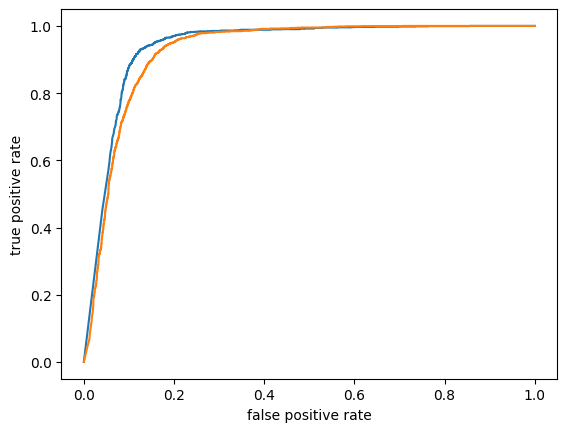

In [ ]:
plt.plot(fpr, tpr)
plt.plot(fpr_opt, tpr_opt)

# plt.plot(fpr_triv,tpr_triv)

# plt.xlabel('false negative rate')
# plt.ylabel('true negative rate')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [ ]:
auc_score = roc_auc_score(y_test, y_prob[:,1])
print('Positive rate auc (10,10,10) = ', auc_score)
auc_score = roc_auc_score(y_test, y_prob_opt[:,1])
print('Positive rate auc (optimal)= ', auc_score)

# auc_score_neg = roc_auc_score((np.ones(np.shape(y_test))-y_test), y_prob[:,0])
# print('negative auc score = ', auc_score_neg)

Positive rate auc (10,10,10) =  0.9390693477700438
Positive rate auc (optimal)=  0.9267438469294618


Q: The AUC score for the optimal mlp is usually lower than that of a randomly specified mlp (why?)

In [ ]:
# fpr_opt_n, tpr_opt_n, thresholds_opt_n = roc_curve(y_test, y_prob_opt[:,0], pos_label=0)
# fpr_n, tpr_n, thresholds_n = roc_curve(y_test, y_prob[:,0], pos_label=0)
# plt.plot(fpr_n, tpr_n)
# plt.plot(fpr_opt_n, tpr_opt_n)
# plt.xlabel('false negative rate')
# plt.ylabel('true negative rate')
# plt.show()

# auc_score = roc_auc_score(1-y_test, y_prob_opt[:,0])
# print('Negative rate auc (opt)= ', auc_score)
# auc_score = roc_auc_score(1-y_test, y_prob[:,0])
# print('Negative rate auc (10,10,10)= ', auc_score)

- Positive rate ROC: High variance in accuracy and AUC score; eg for (10,10,10), AUC score varied between 0.68 - 0.93, accuracy: 70-76%

    high AUC score + low accuracy due to good positive prediction + poor negative prediction

<!-- - Negative rate ROC: AUC consistently high for optimal 3-layer mlp (> 92.5%) -->

- Optimal hyperparameters give poor accuracy (~70%) but consistently high AUC score, between 0.93-0.95.

- Changing size of training set (within reasonable bounds ie <20,000) does not seem to affect this

- Overall accuracy (& negative accuracy) highest at around 2,500/12,500 pos/neg. (Is this because it is closest to the proportion in the test set?)

- AUC score highest at around 5,000/10,000; this makes sense since AUC has some bias towards positive accuracy(?)

- Increasing the proportion of positive training data decreased accuracy of negative prediction as expected

Table below displays accuracy and AUC scores for different proportions of negative/positive training data (size of training dataset fixed)
<!-- & since training size of only <20,000 could run in reasonable time)  -->



| Positive training size | Negative training size | Accuracy (overall) | Accuracy (positive) | Accuracy (negative) | AUC   |
|------------------------|------------------------|--------------------|---------------------|---------------------|-------|
| 500                    | 14,500                 | 0.773              | 0.952               | 0.724               | 0.923 |
| 2,500                  | 12,500                 | 0.795              | 0.974               | 0.745               | 0.935 |
| 5,000                  | 10,000                 | 0.747              | 0.987               | 0.681               | 0.940 |
| 7,500                  | 7,500                  | 0.675              | 0.989               | 0.588               | 0.918 |
| 10,000                 | 5,000                  | 0.689              | 0.990               | 0.606               | 0.938 |

Optimal positive to negative training ratio was around 2500:12500, or 1:5. This produced by the highest (negative) accuracy, and a very good AUC score.

In [ ]:
# Best parameters for a 3-layer MLP: AUC score = 0.94, good

______________

In [ ]:
train_ind = np.zeros(PUL_df.shape[0])
train_ind[:int(np.floor(PUL_df.shape[0]*0.6))] = 1 #prop. train
np.random.shuffle(train_ind)

X_PUL, y_PUL = PUL_df.to_numpy()[:,:-1], PUL_df.to_numpy()[:,-1:]

X_PUL_train, y_PUL_train = X_PUL[train_ind==1,:], y_PUL[train_ind==1]
X_PUL_test, y_PUL_test = X_PUL[train_ind==0,:], y_PUL[train_ind==0,:]

### (b) Only using PUL file for training and testing: (60/40)

[to see if accuracy improves so, for example, something may be wrong with the training dataframe]

In [ ]:
X2_train, y2_train = X_PUL_train, y_PUL_train
X2_test, y2_test = X_PUL_test, y_PUL_test

In [ ]:
mlp2 = MLPClassifier(hidden_layer_sizes=(10,10),
                    activation = 'relu',
                    solver = 'adam',
                    verbose = True).fit(X2_train,y2_train)

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.70889669
Iteration 2, loss = 0.56608791
Iteration 3, loss = 0.51478544
Iteration 4, loss = 0.47753064
Iteration 5, loss = 0.43486368
Iteration 6, loss = 0.39492189
Iteration 7, loss = 0.36396285
Iteration 8, loss = 0.33926983
Iteration 9, loss = 0.31816372
Iteration 10, loss = 0.29941161
Iteration 11, loss = 0.28301677
Iteration 12, loss = 0.26899128
Iteration 13, loss = 0.25644812
Iteration 14, loss = 0.24540742
Iteration 15, loss = 0.23574234
Iteration 16, loss = 0.22753962
Iteration 17, loss = 0.22058173
Iteration 18, loss = 0.21464311
Iteration 19, loss = 0.20973611
Iteration 20, loss = 0.20512615
Iteration 21, loss = 0.20086267
Iteration 22, loss = 0.19808688
Iteration 23, loss = 0.19369995
Iteration 24, loss = 0.18944078
Iteration 25, loss = 0.18620458
Iteration 26, loss = 0.18197621
Iteration 27, loss = 0.17849670
Iteration 28, loss = 0.17634801
Iteration 29, loss = 0.17367596
Iteration 30, loss = 0.17193148
Iteration 31, loss = 0.16879395
Iteration 32, los

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
y2_pred = mlp2.predict(X2_test)

In [ ]:
print(accuracy_score(y2_test,y2_pred))
mat = confusion_matrix(y2_test, y2_pred)
cfmat_df = pd.DataFrame(np.array(mat))
index_, columns_ = ['Not_cazyme','Cazyme'], ['Pred_not_cazyme', 'Pred_cazyme']
cfmat_df.index, cfmat_df.columns = index_, columns_

print(cfmat_df)

print('negative accuracy= ', cfmat_df.iloc[0,0]/sum(cfmat_df.iloc[0,:]))
print('positive accuracy= ', cfmat_df.iloc[1,1]/sum(cfmat_df.iloc[1,:]))


0.9298701298701298
            Pred_not_cazyme  Pred_cazyme
Not_cazyme             2321          130
Cazyme                   86          543
negative accuracy=  0.9469604243166054
positive accuracy=  0.863275039745628


<!-- - 1 layer (10 neurons): 93.2% accuracy,  -->

| Number of layers | Accuracy |
|------------------|----------|
| 2                | 0.929    |
| 3                | 0.931    |
| 4                | 0.932    |

Positive prediction is still quite poor (~86%) but much better than in (a)

Fewer neurons led to poorer positive prediction but not on negative prediction (why?), for example:
- (10,10): 86.0%
- (3,3): 0% (!)


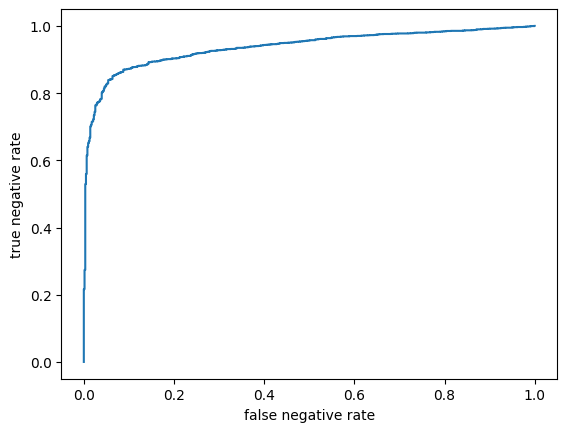

In [ ]:
y2_prob = mlp.predict_proba(X2_test)
fpr2, tpr2, thresholds2 = roc_curve(y2_test, y2_prob[:,0], pos_label=0)
plt.plot(fpr2, tpr2)
plt.xlabel('false negative rate')
plt.ylabel('true negative rate')
plt.show()

In [ ]:
auc2_score = roc_auc_score(y2_test, y2_prob[:,1])
print('auc = ', auc2_score)

auc =  0.9369787744400747


AUC score (10,10): 0.93

No change in AUC score compared to (a), but large increase in accuracy (in particular, positive prediction)

_____________

### [Aside:] Histogram of no. cazymes in each PUL:
- `caz_res` = no. cazymes in each PUL
- `caz_res_frac` = proportion cazymes in each PUL
- `caz_res_len` = total no. proteins in each PUL


In [26]:
# grouping proteins in the same PUL:
#y-axis: count
#x-axis: frequency of cazymes in one PUL
test_list=PUL_keys
def util_func(x, y): return x[0] == y[0]

res = []
for sub in test_list:
    ele = sub.split('_')
    ele_cat = next((x for x in res if util_func(ele,str(x[0]).split('_'))), [])
    if ele_cat == []:
        res.append(ele_cat)
    ele_cat.append(sub)

print("list after categorisation : " + str(res))
len(res) # PUL0076 is missing!

list after categorisation : [['PUL0001_1', 'PUL0001_10', 'PUL0001_11', 'PUL0001_12', 'PUL0001_13', 'PUL0001_14', 'PUL0001_15', 'PUL0001_2', 'PUL0001_3', 'PUL0001_4', 'PUL0001_5', 'PUL0001_6', 'PUL0001_7', 'PUL0001_8', 'PUL0001_9'], ['PUL0002_1', 'PUL0002_2'], ['PUL0003_1', 'PUL0003_2'], ['PUL0004_1', 'PUL0004_2'], ['PUL0005_1', 'PUL0005_2'], ['PUL0006_1', 'PUL0006_10', 'PUL0006_11', 'PUL0006_2', 'PUL0006_3', 'PUL0006_4', 'PUL0006_5', 'PUL0006_6', 'PUL0006_7', 'PUL0006_8', 'PUL0006_9'], ['PUL0007_1', 'PUL0007_2', 'PUL0007_3', 'PUL0007_4', 'PUL0007_5', 'PUL0007_6', 'PUL0007_7', 'PUL0007_8'], ['PUL0008_1', 'PUL0008_10', 'PUL0008_11', 'PUL0008_12', 'PUL0008_2', 'PUL0008_3', 'PUL0008_4', 'PUL0008_5', 'PUL0008_6', 'PUL0008_7', 'PUL0008_8', 'PUL0008_9'], ['PUL0009_1', 'PUL0009_10', 'PUL0009_11', 'PUL0009_12', 'PUL0009_13', 'PUL0009_14', 'PUL0009_15', 'PUL0009_2', 'PUL0009_3', 'PUL0009_4', 'PUL0009_5', 'PUL0009_6', 'PUL0009_7', 'PUL0009_8', 'PUL0009_9'], ['PUL0010_1', 'PUL0010_10', 'PUL0010_11

601

In [ ]:
ind=0
caz_res=[]

for i in range(len(res)):
    indtemp=ind
    caz_res.append(sum(np.array(PUL_df.iloc[indtemp:indtemp+len(res[i]),-1])))
    ind=indtemp+len(res[i])
    # if caz_res[i]== 0:
    #     print(res[i])
# print(caz_res)

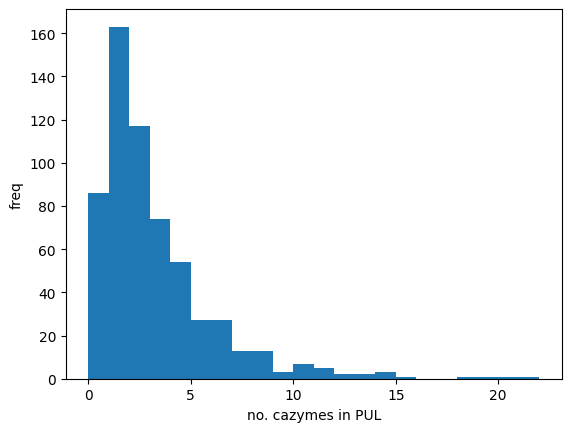

In [ ]:
plt.hist(caz_res, bins = range(min(caz_res),max(caz_res)+1))
plt.xlabel('no. cazymes in PUL'), plt.ylabel('freq')
plt.show()

Histogram of proportion cazymes in each PUL:

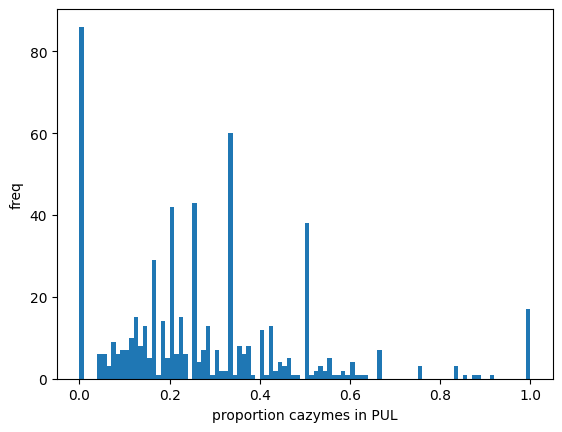

In [ ]:
ind=0
caz_res_frac=[]
for i in range(len(res)):
    indtemp=ind
    caz_res_frac.append((sum(np.array(PUL_df.iloc[indtemp:indtemp+len(res[i]),-1])))/len(res[i]))
    ind=indtemp+len(res[i])
# print(caz_res_frac)

plt.hist(caz_res_frac, bins = 100)
plt.xlabel('proportion cazymes in PUL'), plt.ylabel('freq')
plt.show()

- Largest spike at 0 - this is unexpected, since we expect each PUL to contain at least one cazyme!
- Spikes at ~0.33, 0.5 and 1 - this could be due to PULs containing only few (1-3) proteins? (A histogram of PUL length, shown below confirms this; the marjority of PULs are below length 10, which may include dimers and trimers.)
- Most PULs lie below 0.5.

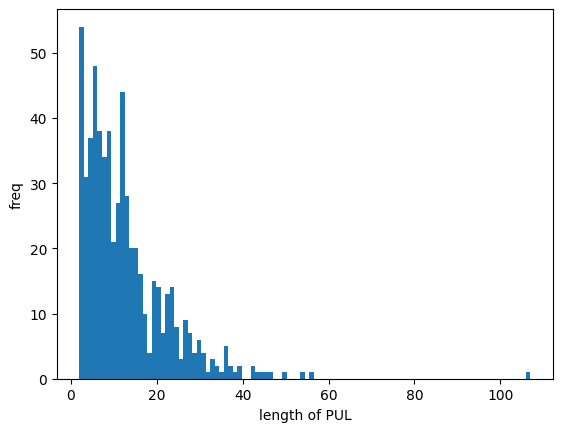

In [33]:
PUL_len=[]
for x in res:
    PUL_len.append(len(x))

plt.hist(PUL_len, bins = 100)
plt.xlabel('length of PUL'), plt.ylabel('freq')
plt.show()

___


## Conclusion:

It was found that the best training ratio to predict CAZymes/non-CAZymes was 1:5 (positive:negative). This may be due to the majority occurence of non-cazymes, so a large proportion of negative training data was required. In addition, it was found that negative accuracy was always far poorer (~0.7) than positive accuracy (>0.9).

Using RandomizedSearchCV to find optimal hyperparameters resulted in a wide range of results upon iteration, but the majority produced an accuracy of ~0.79 and and an AUC score of ~0.93.

